# White Box Models for Pipelines


In [58]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from white_box_single_pipeline import scan_branched_op
from white_box_single_pipeline import build_probe_op
from util import figsize


## Scan Pipeline


,tablerows,tablesizekb,selectivity,tuplewidth,attrInPred,runtime,operator
0,1250000,5000,0.000000,1,1,8474,branch
1,1250000,5000,0.050000,1,1,11526,branch
2,1250000,5000,0.100000,1,1,9590,branch
3,1250000,5000,0.150000,1,1,10710,branch
4,1250000,5000,0.200000,1,1,11752,branch
5,1250000,5000,0.250000,1,1,13069,branch
6,1250000,5000,0.300000,1,1,14456,branch
7,1250000,5000,0.350000,1,1,15768,branch
8,1250000,5000,0.400000,1,1,16523,branch
9,1250000,5000,0.450000,1,1,17353,branch


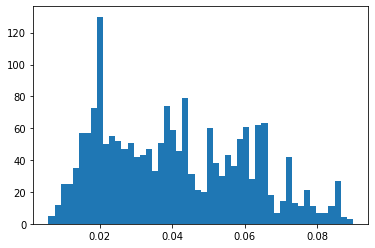

In [10]:

df = pd.read_csv("data/simple_sel_pipeline.csv")
plt.hist(df['runtime']/df['tablerows'], bins=50)
df


/mnt/c/Users/hilpr/Documents/cidr-cost-model/venv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


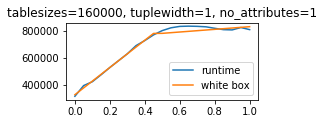

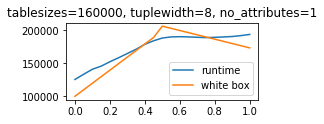

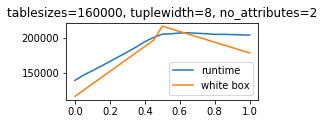

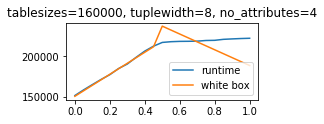

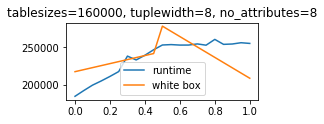

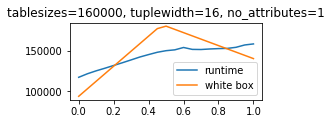

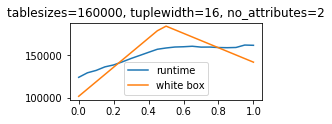

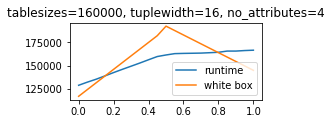

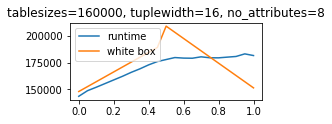

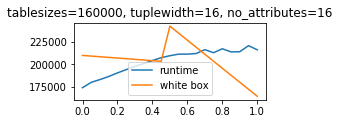

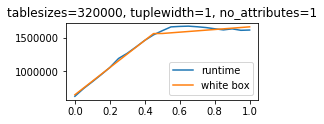

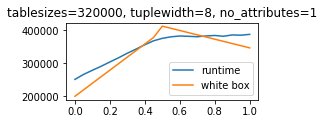

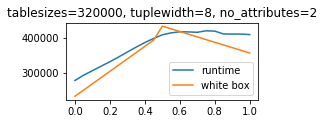

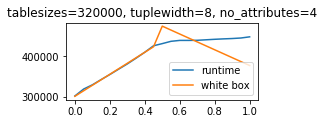

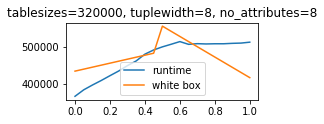

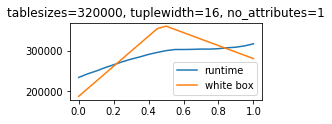

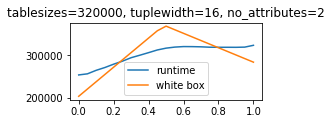

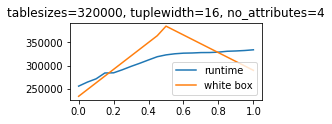

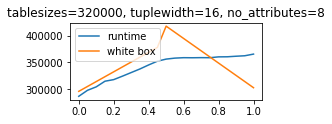

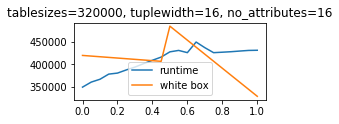

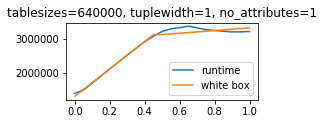

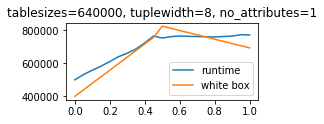

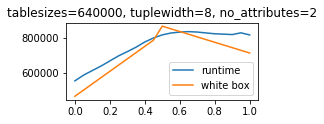

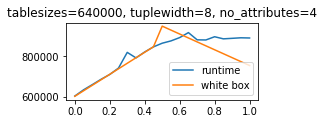

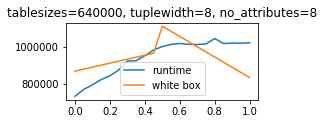

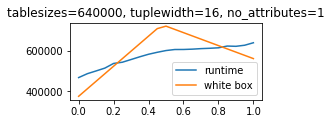

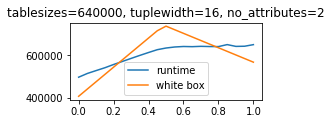

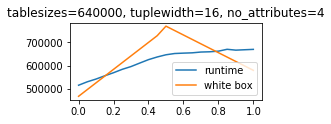

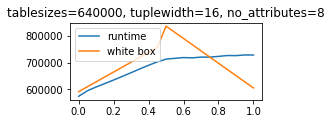

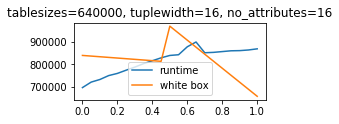

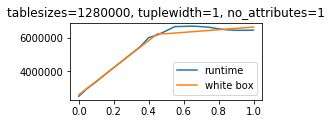

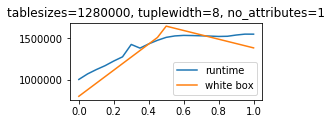

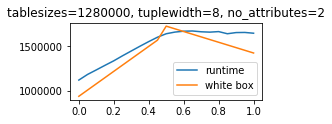

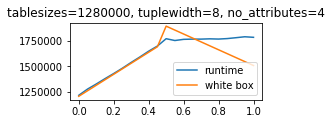

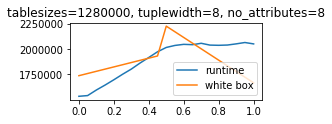

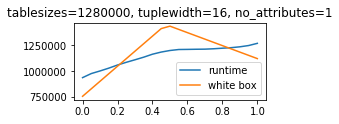

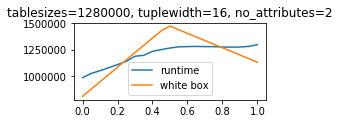

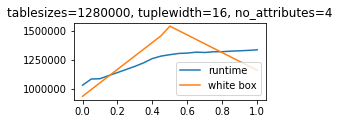

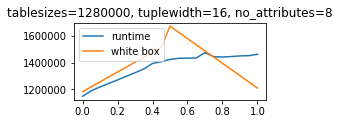

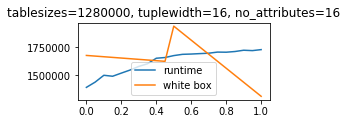

In [57]:
df = pd.read_csv("data/simple_sel_pipeline.csv")

# scan_larger_160k_train_100
with open('models/white_box/training_data_share/scan_larger_160k_train_10.pickle', 'rb') as handle:
    white_box_params = pickle.load(handle)

def estimate_per_row(df_row):
    return scan_branched_op(params=white_box_params, selectivity=df_row['selectivity'], 
                            tuple_width=df_row['tuplewidth'], no_predicates=df_row['attrInPred'], 
                            no_tuples=df_row['tablerows'], tablesize=df_row['tablerows']).item()

df['white_box_estimate'] = df.apply(estimate_per_row, axis=1)

tuple_widths = df.tuplewidth.unique()
tablesizes = df.tablesizekb.unique()

for ts in tablesizes:
    for tw in tuple_widths:
        if ts < 160000:
            continue
        df_temp_big = df.query("tuplewidth == " + str(tw) + " & tablesizekb == " + str(ts) )
        if len(df_temp_big.index) > 0:
            averaged_data = df_temp_big[['attrInPred', 'selectivity', 'runtime', 'white_box_estimate']].groupby(['attrInPred', 'selectivity']).mean().reset_index()
            for attrInPred in averaged_data['attrInPred'].unique():
                plot_data = averaged_data[averaged_data.attrInPred == attrInPred]
                
                plt.figure(figsize=figsize())
                plt.title(f"tablesizes={ts}, tuplewidth={tw}, no_attributes={attrInPred}")
                plt.plot(plot_data['selectivity'], plot_data['runtime'], label="runtime")
                plt.plot(plot_data['selectivity'], plot_data['white_box_estimate'], label="white box")
                plt.legend()


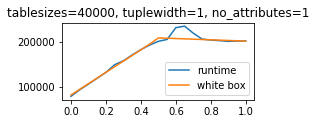

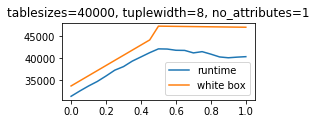

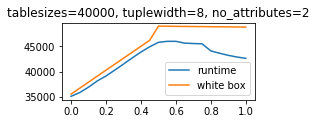

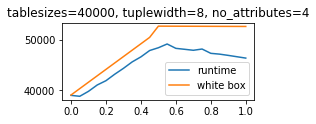

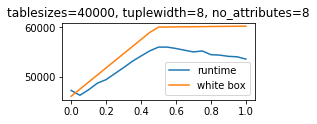

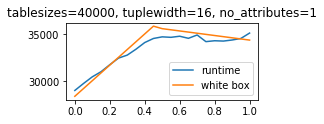

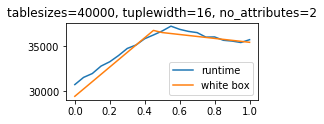

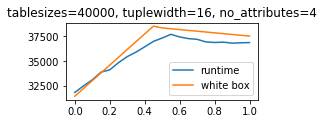

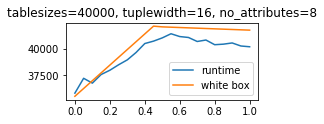

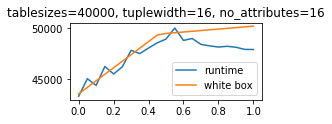

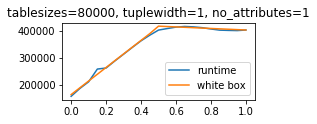

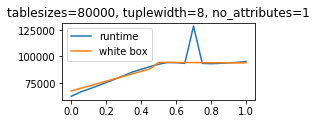

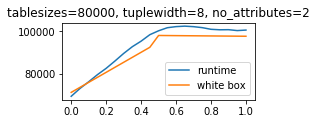

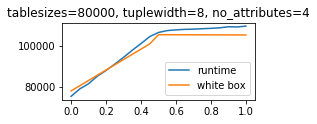

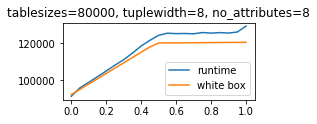

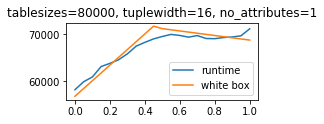

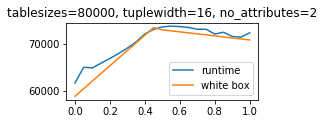

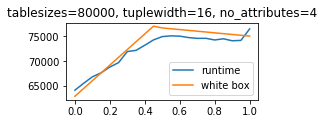

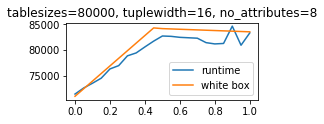

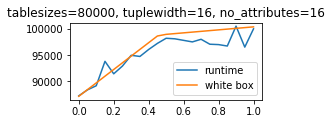

In [52]:
df = pd.read_csv("data/simple_sel_pipeline.csv")

with open('models/white_box/scan_40k_80k.pickle', 'rb') as handle:
    white_box_params = pickle.load(handle)

def estimate_per_row(df_row):
    return scan_branched_op(params=white_box_params, selectivity=df_row['selectivity'], 
                            tuple_width=df_row['tuplewidth'], no_predicates=df_row['attrInPred'], 
                            no_tuples=df_row['tablerows'], tablesize=df_row['tablerows']).item()

df['white_box_estimate'] = df.apply(estimate_per_row, axis=1)

tuple_widths = df.tuplewidth.unique()
tablesizes = df.tablesizekb.unique()

for ts in tablesizes:
    for tw in tuple_widths:
        if not (40000 <= ts <= 80000):
            continue
        df_temp_big = df.query("tuplewidth == " + str(tw) + " & tablesizekb == " + str(ts) )
        if len(df_temp_big.index) > 0:
            averaged_data = df_temp_big[['attrInPred', 'selectivity', 'runtime', 'white_box_estimate']].groupby(['attrInPred', 'selectivity']).mean().reset_index()
            for attrInPred in averaged_data['attrInPred'].unique():
                plot_data = averaged_data[averaged_data.attrInPred == attrInPred]
                
                plt.figure(figsize=figsize())
                plt.title(f"tablesizes={ts}, tuplewidth={tw}, no_attributes={attrInPred}")
                plt.plot(plot_data['selectivity'], plot_data['runtime'], label="runtime")
                plt.plot(plot_data['selectivity'], plot_data['white_box_estimate'], label="white box")
                plt.legend()


## Build Hashtable Pipeline


[  40000   80000  160000  320000  640000 1280000]


/mnt/c/Users/hilpr/Documents/cidr-cost-model/venv/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


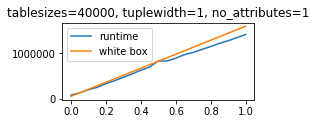

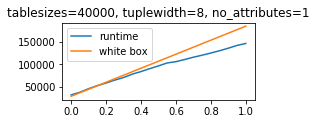

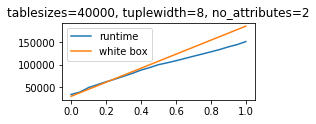

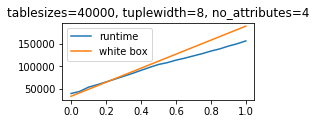

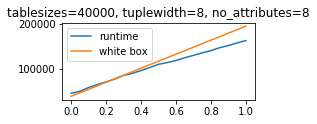

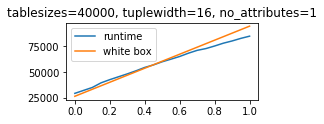

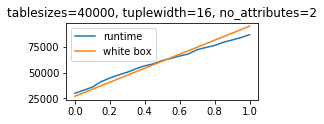

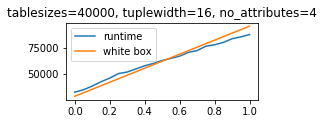

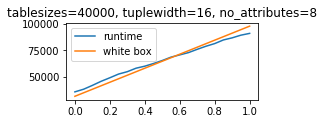

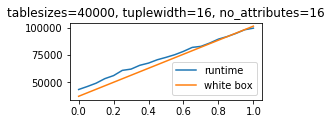

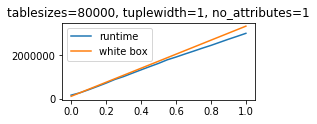

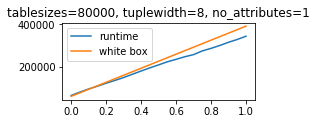

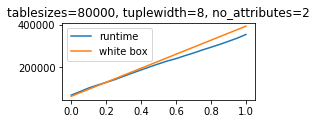

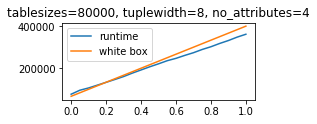

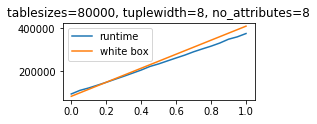

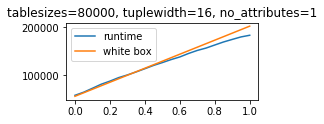

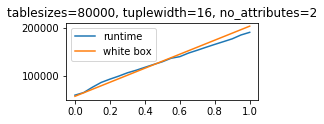

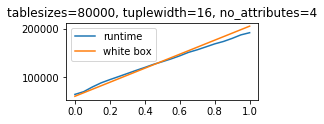

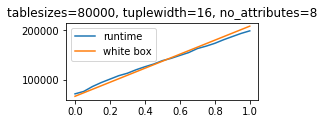

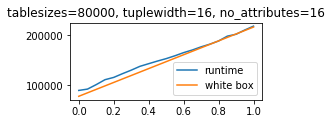

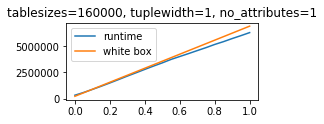

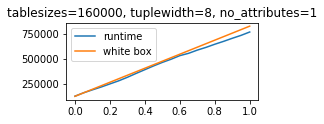

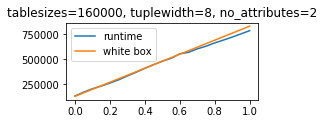

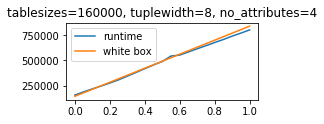

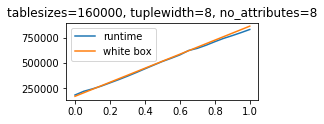

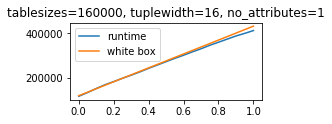

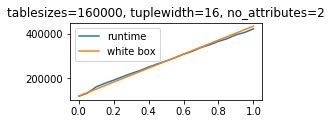

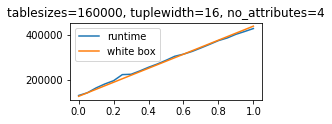

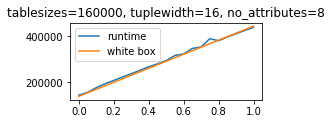

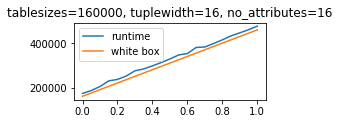

In [60]:
df = pd.read_csv("data/build_pipeline.csv")

with open('models/white_box/build_smaller_160k.pickle', 'rb') as handle:
    white_box_params = pickle.load(handle)

# fixme
# proof of bug...
def estimate_per_row(df_row):
    return 0.75 * build_probe_op(params=white_box_params, selectivity=df_row['selectivity'], 
                          tuple_width=df_row['tuplewidth'], no_predicates=df_row['attrInPred'], 
                          no_tuples=df_row['tablerows'], tablesize=df_row['tablerows']).item()

df['white_box_estimate'] = df.apply(estimate_per_row, axis=1)

tuple_widths = df.tuplewidth.unique()
tablesizes = df.tablesizekb.unique()
print(tablesizes)

for ts in tablesizes:
    for tw in tuple_widths:
        if ts > 160000:
            continue
        df_temp_big = df.query("tuplewidth == " + str(tw) + " & tablesizekb == " + str(ts) )
        if len(df_temp_big.index) > 0:
            averaged_data = df_temp_big[['attrInPred', 'selectivity', 'runtime', 'white_box_estimate']].groupby(['attrInPred', 'selectivity']).mean().reset_index()
            for attrInPred in averaged_data['attrInPred'].unique():
                plot_data = averaged_data[averaged_data.attrInPred == attrInPred]
                
                plt.figure(figsize=figsize())
                plt.title(f"tablesizes={ts}, tuplewidth={tw}, no_attributes={attrInPred}")
                plt.plot(plot_data['selectivity'], plot_data['runtime'], label="runtime")
                plt.plot(plot_data['selectivity'], plot_data['white_box_estimate'], label="white box")
                plt.legend()


/mnt/c/Users/hilpr/Documents/cidr-cost-model/venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


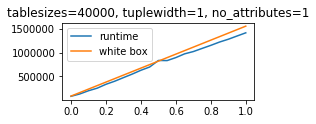

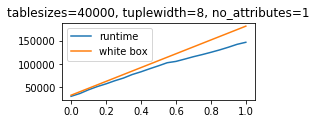

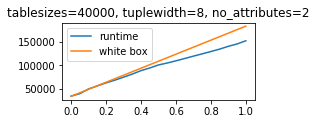

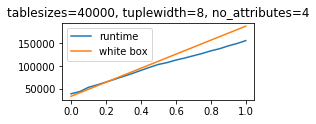

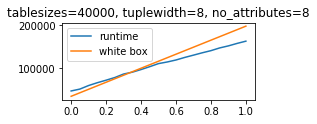

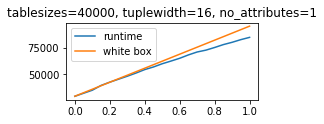

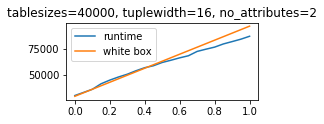

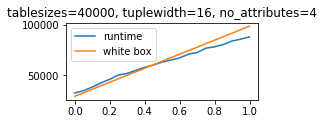

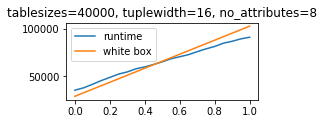

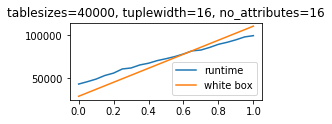

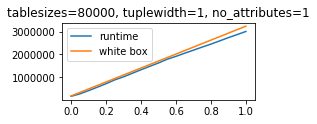

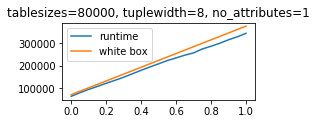

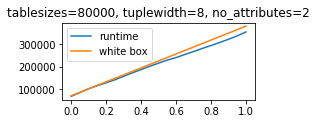

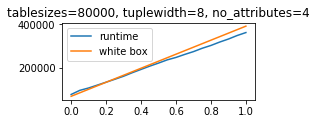

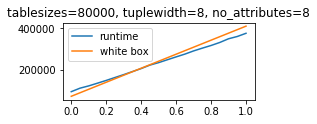

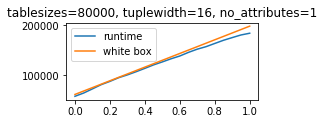

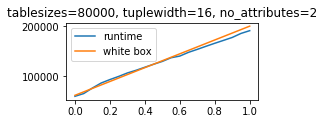

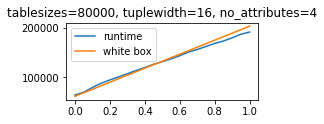

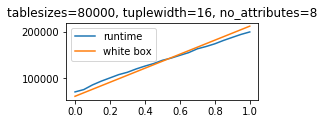

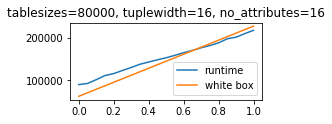

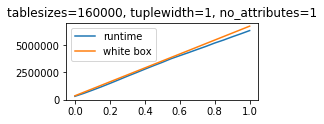

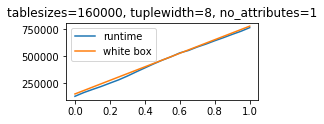

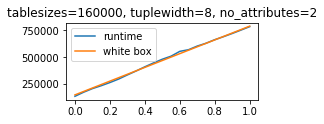

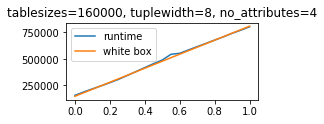

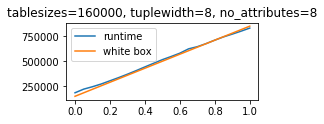

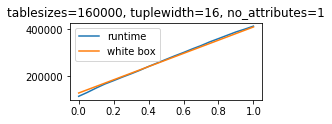

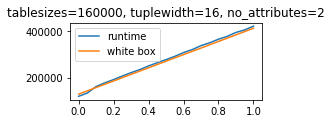

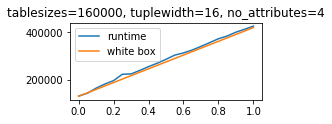

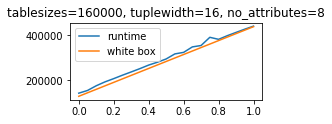

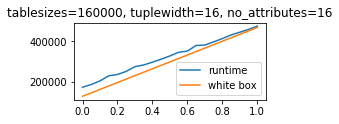

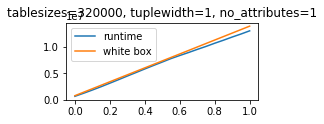

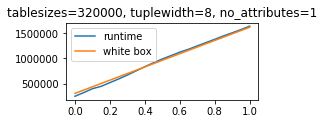

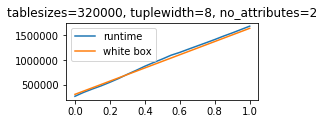

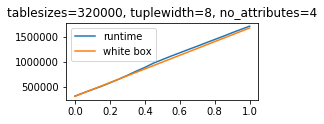

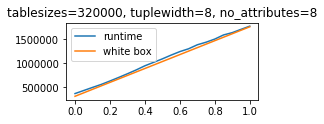

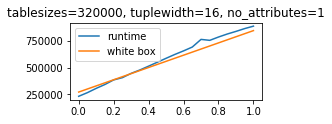

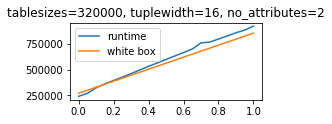

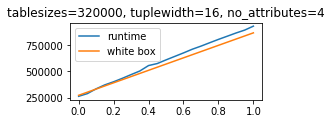

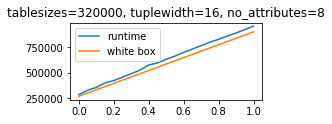

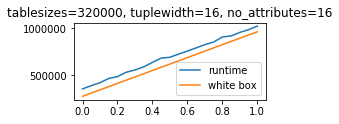

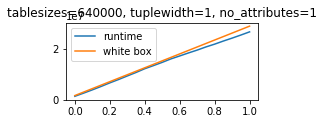

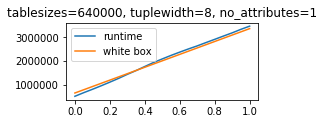

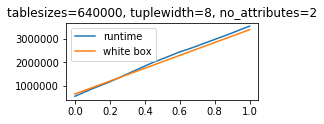

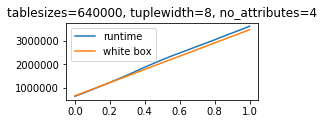

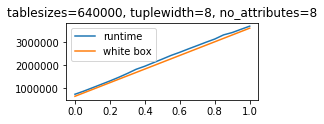

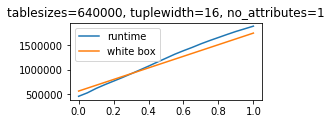

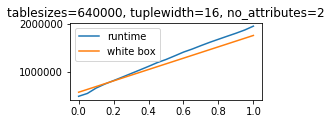

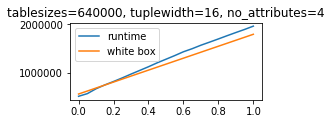

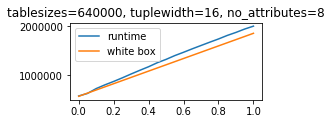

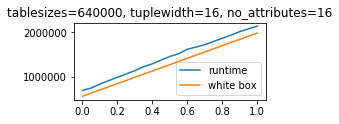

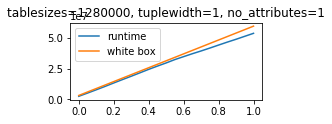

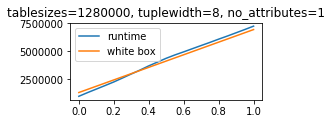

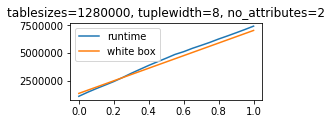

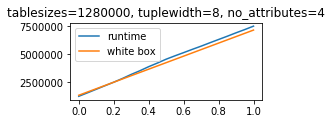

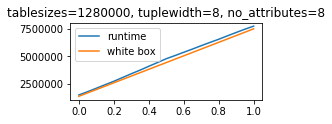

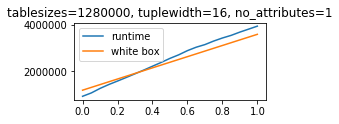

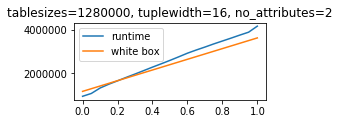

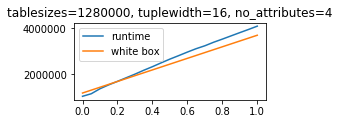

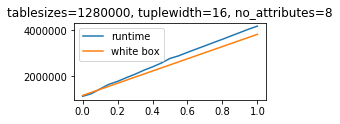

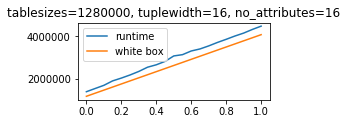

In [67]:
df = pd.read_csv("data/build_pipeline.csv")

with open('models/white_box/build_larger_320k_train_100.pickle', 'rb') as handle:
    white_box_params = pickle.load(handle)

# fixme
def estimate_per_row(df_row):
    return 0.8 * build_probe_op(params=white_box_params, selectivity=df_row['selectivity'], 
                          tuple_width=df_row['tuplewidth'], no_predicates=df_row['attrInPred'], 
                          no_tuples=df_row['tablerows'], tablesize=df_row['tablerows']).item()

df['white_box_estimate'] = df.apply(estimate_per_row, axis=1)

tuple_widths = df.tuplewidth.unique()
tablesizes = df.tablesizekb.unique()

for ts in tablesizes:
    for tw in tuple_widths:
        df_temp_big = df.query("tuplewidth == " + str(tw) + " & tablesizekb == " + str(ts) )
        if len(df_temp_big.index) > 0:
            averaged_data = df_temp_big[['attrInPred', 'selectivity', 'runtime', 'white_box_estimate']].groupby(['attrInPred', 'selectivity']).mean().reset_index()
            for attrInPred in averaged_data['attrInPred'].unique():
                plot_data = averaged_data[averaged_data.attrInPred == attrInPred]
                
                plt.figure(figsize=figsize())
                plt.title(f"tablesizes={ts}, tuplewidth={tw}, no_attributes={attrInPred}")
                plt.plot(plot_data['selectivity'], plot_data['runtime'], label="runtime")
                plt.plot(plot_data['selectivity'], plot_data['white_box_estimate'], label="white box")
                plt.legend()


## Probe Hashtable Pipeline


/mnt/c/Users/hilpr/Documents/cidr-cost-model/venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


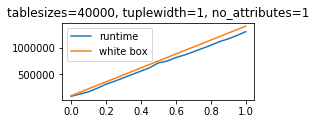

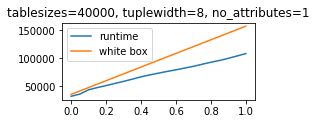

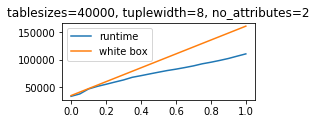

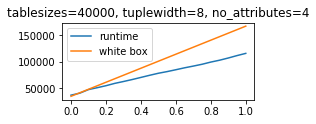

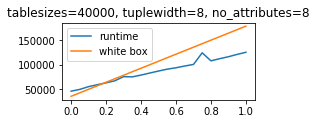

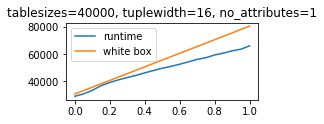

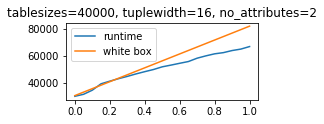

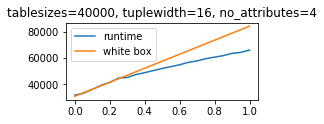

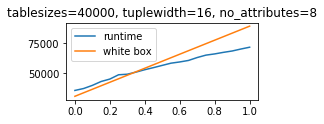

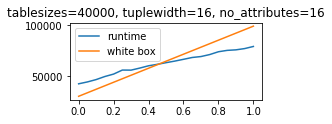

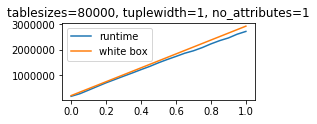

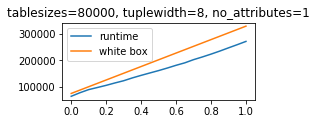

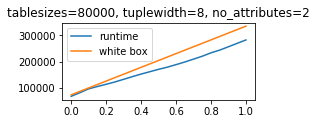

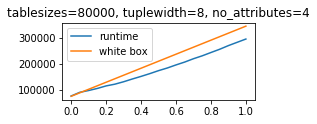

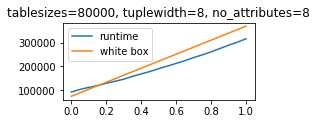

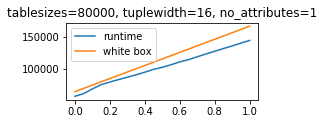

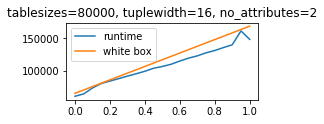

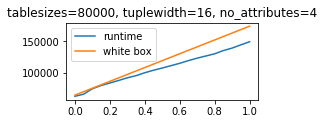

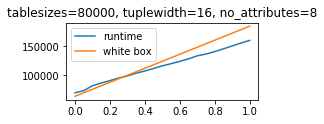

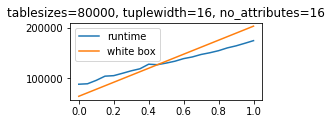

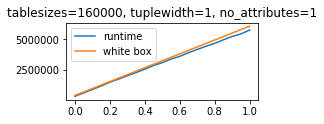

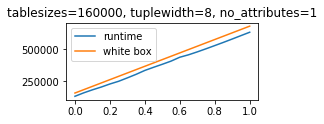

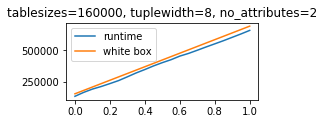

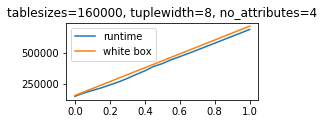

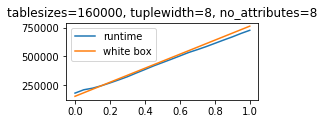

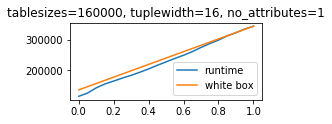

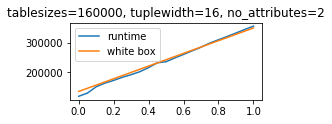

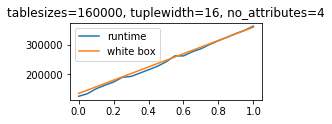

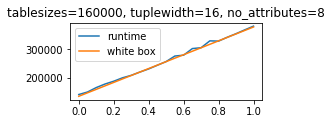

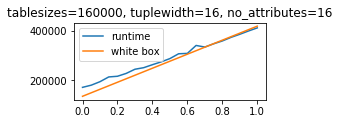

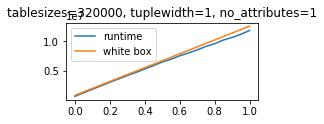

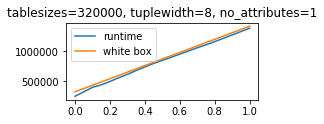

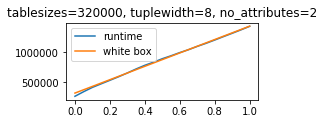

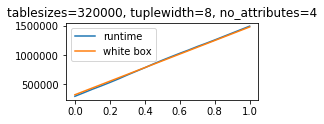

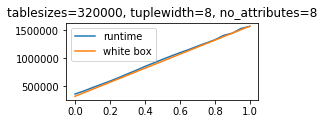

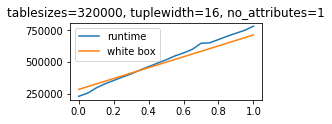

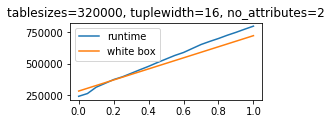

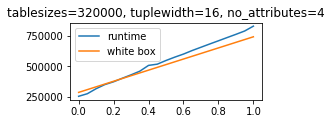

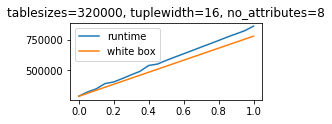

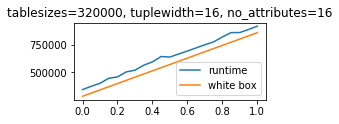

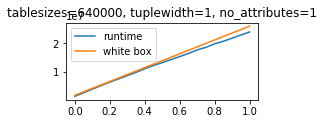

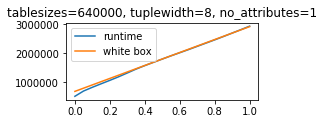

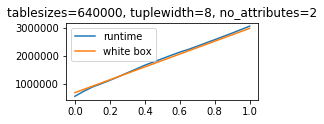

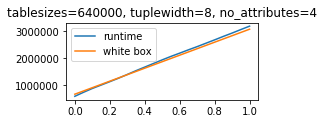

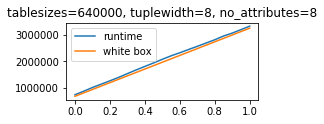

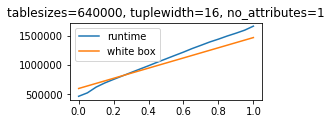

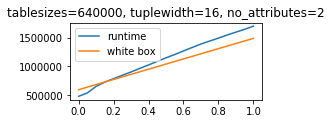

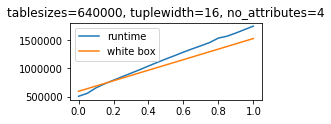

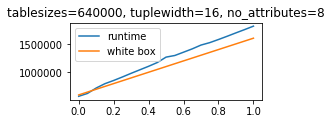

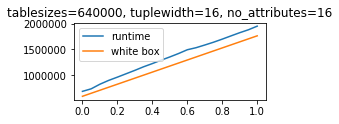

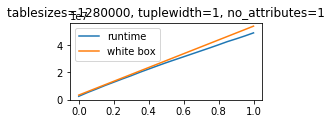

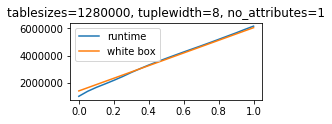

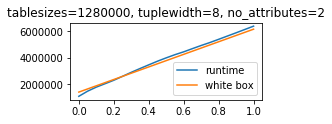

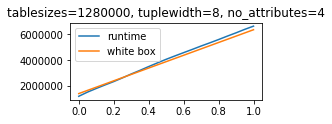

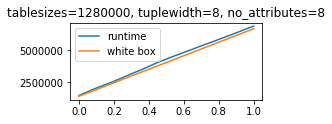

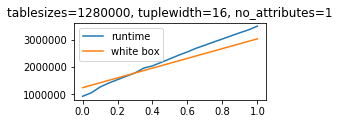

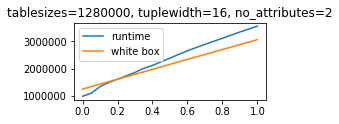

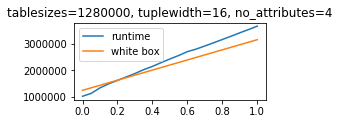

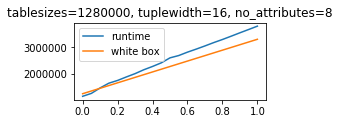

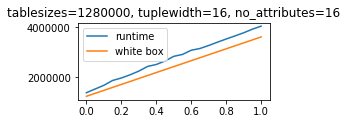

In [70]:
df = pd.read_csv("data/probe_pipeline.csv")

with open('models/white_box/probe_larger_320k_train_100.pickle', 'rb') as handle:
    white_box_params = pickle.load(handle)

def estimate_per_row(df_row):
    return 0.8 * build_probe_op(params=white_box_params, selectivity=df_row['selectivity'], 
                          tuple_width=df_row['tuplewidth'], no_predicates=df_row['attrInPred'], 
                          no_tuples=df_row['tablerows'], tablesize=df_row['tablerows']).item()

df['white_box_estimate'] = df.apply(estimate_per_row, axis=1)

tuple_widths = df.tuplewidth.unique()
tablesizes = df.tablesizekb.unique()

for ts in tablesizes:
    for tw in tuple_widths:
        df_temp_big = df.query("tuplewidth == " + str(tw) + " & tablesizekb == " + str(ts) )
        if len(df_temp_big.index) > 0:
            averaged_data = df_temp_big[['attrInPred', 'selectivity', 'runtime', 'white_box_estimate']].groupby(['attrInPred', 'selectivity']).mean().reset_index()
            for attrInPred in averaged_data['attrInPred'].unique():
                plot_data = averaged_data[averaged_data.attrInPred == attrInPred]
                
                plt.figure(figsize=figsize(0.5))
                plt.title(f"tablesizes={ts}, tuplewidth={tw}, no_attributes={attrInPred}")
                plt.plot(plot_data['selectivity'], plot_data['runtime'], label="runtime")
                plt.plot(plot_data['selectivity'], plot_data['white_box_estimate'], label="white box")
                plt.legend()
